In [1]:
pip install notebook selenium

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 9.4/9.4 MB 1.6 MB/s eta 0:00:00
     -------------------------------------- 499.2/499.2 kB 1.4 MB/s eta 0:00:00
     ---------------------------------------- 45.8/45.8 kB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 58.8/58.8 kB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 63.8/63.8 kB 1.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
import string
from csv import writer
import requests
import re
import regex
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options

In [4]:
#Here i define the selenium's driver's options
options = Options()
options.add_argument("--headless")
#optional
options.add_argument('--disable-gpu')


These options where needed so as not to open everytime i was running the programm the selenium driver


In [5]:
#initial page's url
page_url = "https://areiospagos.gr/"
r = requests.get(page_url)
#necessary to correctly recognize greek
r.encoding = r.apparent_encoding
soup = BeautifulSoup(r.content, "html.parser")

#finds the area of the page which has the href i want
frame = soup.find("frameset").find("frame", {"name" : "contents"})
frame_src = frame.get("src")

First i got the html of the initial page

In [6]:
#creates a valid url with the teo hrefs
if not frame_src.startswith("http"):
    from urllib.parse import urljoin
    frame_src = urljoin("https://areiospagos.gr/", frame_src)

frame_html = requests.get(frame_src)
frame_html.encoding = frame_html.apparent_encoding

frame_soup = BeautifulSoup(frame_html.text, "html.parser")

Then i got the html of its frame

In [10]:
#here i find the needed anchor element
a_decisions = frame_soup.find("body").find("a", {"href" : "nomologia/apofaseis.asp"})
next_page_url = urljoin(page_url, a_decisions["href"])


Then i created a valid url from the needed anchor element

In [9]:
#opens a selenium driver as the page has javascript
driver = webdriver.Chrome(options=options)
driver.get(next_page_url)

inputElement = driver.find_element(By.NAME, "x_ETOS")
inputElement.send_keys("2024")

submitButton = driver.find_element(By.NAME, "submit_krit")
submitButton.click()

#makes the driver to wait until every needed html element has loaded
WebDriverWait(driver, 10).until(
    EC.presence_of_all_elements_located((By.TAG_NAME, "a"))
)

wantedPageSoup = BeautifulSoup(driver.page_source, "html.parser")


I used selenium to send the data i wanted as the page had javascript

In [11]:
pattern = re.compile(r'ΠΟΛΙΤΙΚΕΣ|ΠΟΙΝΙΚΕΣ', re.UNICODE)

anchors = wantedPageSoup.find_all("a", href=pattern)
neededUrl = urljoin(page_url, "nomologia")
finalResult = {
    "year" : [],
    "number" : [],
    "department" : [],
    "department number" : [],
    "judges" : [],
    "entry text" : [],
    "final text" : [],
    "ΠΚ" : [],
    "ΚΠΔ" : [],
    "ΚΠολΔ" : [],
    "ΑΚ" : []
}
pagesToIgnore = [ 2318, 2159, 1923, 1881, 1882, 1838, 1669, 1666, 1622, 1590, 1500, 1460, 1310, 1229, 1199, 1284, 1218, 1067, 1040, 1380, 1021, 995, 996, 997, 998, 994, 993, 899, 774, 745, 719, 641, 637, 1444, 593, 534, 1464, 464, 1493, 1508, 339, 1495, 328, 286, 2425, 2426, 1810, 1577, 2274, 1670, 1487, 2306, 261, 196, 183, 158, 46]

Initialized my dictionary and manually ignored some pages that had some errors i could not handle

In [ ]:
#this function finds all the articles used in each decision
def findArticleIdentifiers(text : string):
    result = {"ΚΠολΔ" : [], "ΑΚ" : [], "ΚΠΔ" : [], "ΠΚ" : []}
    #finds the vast majority of articles for code of political justice
    matchKPolDTypes = re.findall(r'(?:\([^\)]*\))?\s*(?:άρθρο|άρθρων|άρθρα|άρθρου|άρθρ\.|αρθ\.)\s*((?:\d+(?:\s*,\s*|\s*και\s*)?|\s*παρ\.\s*\d+\s*,?\s*)+)\s+[^ν]*?\bΚΠολΔ\b', text)
    cleanedMatchKPolDTypes = [re.sub(r'\s*παρ\.\s*\d+', '', m[0], flags=re.IGNORECASE) for m in matchKPolDTypes]
    matchKPolDTypesFirst = re.findall(r'ΚΠολΔ\s*(\d+(?:\s*,\s*\d+)*)', text)

    #finds the vast majority of articles for civilian code
    matchAKTypes = re.findall(r'(?:\([^\)]*\))?\s*(?:άρθρο|άρθρων|άρθρα|άρθρου|άρθρ\.|αρθ\.)\s*((?:\d+(?:\s*,\s*|\s*και\s*)?|\s*παρ\.\s*\d+\s*,?\s*)+)\s+[^ν]*?\bΑΚ\b', text, re.DOTALL)
    cleanedMatchAKTypes = [re.sub(r'\s*παρ\.\s*\d+', '', m[0], flags=re.IGNORECASE) for m in matchAKTypes]
    matchAKTypesFirst = re.findall(r'ΑΚ\s*(\d+(?:\s*,\s*\d+)*)', text)

    result["ΚΠολΔ"].extend(cleanedMatchKPolDTypes)
    result["ΚΠολΔ"].extend(matchKPolDTypesFirst)
    result["ΑΚ"].extend(cleanedMatchAKTypes)
    result["ΑΚ"].extend(matchAKTypesFirst)

    #finds the vast majority of articles for code of criminal procedure
    matchKPDTypes = re.findall(r'(?:\([^\)]*\))?\s*(?:άρθρο|άρθρων|άρθρα|άρθρου|άρθρ\.|αρθ\.)\s*((?:\d+(?:\s*,\s*|\s*και\s*)?|\s*παρ\.\s*\d+\s*,?\s*)+)\s+[^ν]*?\b(ΚΠΔ|Κ.Ποιν.Δ|ΚΠοινΔ)\b', text)
    cleanedKPDTypes = [re.sub(r'\s*παρ\.\s*\d+', '', m[0], flags=re.IGNORECASE) for m in matchKPDTypes]
    matchKPDTypesFirst = re.findall(r'(ΚΠΔ|Κ.Ποιν.Δ|ΚΠοινΔ)\s*(\d+(?:\s*,\s*\d+)*)', text)

    #finds the vast majority of articles for criminal code
    matchPKTypes = re.findall(r'(?:\([^\)]*\))?\s*(?:άρθρο|άρθρων|άρθρα|άρθρου|άρθρ\.|αρθ\.)\s*((?:\d+(?:\s*,\s*|\s*και\s*)?|\s*παρ\.\s*\d+\s*,?\s*)+)\s+[^ν]*?\b(ΠΚ)\b', text)
    cleanedPKTypes = [re.sub(r'\s*παρ\.\s*\d+', '', m[0], flags=re.IGNORECASE) for m in matchPKTypes]
    matchPKTypesFirst = re.findall(r'(ΠΚ)\s*(\d+(?:\s*,\s*\d+)*)', text)

    result["ΚΠΔ"].extend(cleanedKPDTypes)
    result["ΚΠΔ"].extend(matchKPDTypesFirst)
    result["ΠΚ"].extend(cleanedPKTypes)
    result["ΠΚ"].extend(matchPKTypesFirst)
    return result

This function checks all the articles used in a text

In [ ]:
for i in range(2425):
    if(i in pagesToIgnore):
        continue
    decision1 = requests.get(neededUrl + "/" + anchors[i].get("href"))
    decision1.encoding = decision1.apparent_encoding

    decision1Soup = BeautifulSoup(decision1.text, "html.parser")
    text = decision1Soup.get_text(separator=" ", strip=True)
    text = re.sub(r'\s+', ' ', text).strip()
    
    match_decision = re.search(r'(?:ΑΡΙΘΜΟΣ|Αριθμός|Απόφαση)\s*(\d+)\s*/\s*(\d{4})\s*\(([^,]+),\s*([^)]+)\)', text)

    if match_decision:
        decision_id, decision_year, division_number, raw_division_type = match_decision.groups()
        if "ΠΟΛΙΤΙΚΕΣ" in raw_division_type.upper():
            division_type = "Πολιτικό"
        elif "ΠΟΙΝΙΚΕΣ" in raw_division_type.upper():
            division_type = "Ποινικό"
        else:
            division_type = None
    else:
        decision_id, decision_year, division_number, division_type = None, None, None, None
    finalResult["number"].append(decision_id)
    finalResult["year"].append(decision_year)
    finalResult["department number"].append(division_number)
    finalResult["department"].append(division_type)
    #finds the sentence which includes all the participating judges
    matchJudgesText = re.search(r'(?:Συγκροτήθηκε|ΣΥΓΚΡΟΤΗΘΗΚΕ) από τους (?:Δικαστές|δικαστές)[,:]?\s*(.*?)(ΣΥΝΗΛΘΕ|Συνήλθε|Με την παρουσία|Συνεδρίασε|ΣΥΝΕΔΡΙΑΣΕ|και του Γραμματέα|Κατόπιν|Ακολούθως)',text, re.DOTALL)
    finalResult["judges"].append(matchJudgesText.group())

    #finds the first text needed
    matchText1 = re.search(r'((?:Τ\s*Ο\s*Δ\s*Ι\s*Κ\s*Α\s*Σ\s*Τ\s*Η\s*Ρ\s*Ι\s*Ο\s*Τ\s*Ο\s*Υ\s*Α\s*Ρ\s*Ε\s*Ι\s*Ο\s*Υ\s*Π\s*Α\s*Γ\s*Ο\s*Υ)[\s\S]*?)(?=(Συγκροτήθηκε|ΣΥΓΚΡΟΤΗΘΗΚΕ))', text)
    clean_result = re.sub(r'\s+', ' ', matchText1.group()).strip()
    finalResult["entry text"].append(clean_result)

    #finds the second text needed
    pattern = regex.compile(r'ΓΙΑ ΤΟΥ(Σ)?\s*ΛΟΓΟΥΣ(?: ΑΥΤΟΥΣ)?[\s\S]*', flags=regex.UNICODE)
    matchText2 = pattern.search(text)
    clean_result = re.sub(r'\s+', ' ', matchText2.group()).strip()
    finalResult["final text"].append(clean_result)

    result = findArticleIdentifiers(text)
    finalResult["ΑΚ"].append(result["ΑΚ"])
    finalResult["ΚΠΔ"].append(result["ΚΠΔ"])
    finalResult["ΚΠολΔ"].append(result["ΚΠολΔ"])
    finalResult["ΠΚ"].append(result["ΠΚ"])

#manually shutting down the driver
driver.quit()

Στο προηγούμενο κελί δεν υπάρχουν τα αποτελέσματα όπως και στο επόμενο καθώς είναι αρκετά χρονοβόρα η εκτέλεση

In [ ]:
#Here i write all my data in a csv file in a transpose format
with open(f"save/data.csv", "w", encoding="utf-8") as f:
    wr = writer(f)
    #Headers
    wr.writerow(finalResult.keys())
    lists : list = list(finalResult.values())
    for i in range(len(lists[0])):
        row = []
        for column in lists:
            row.append(column[i])
        wr.writerow(row)
print("Saved data...")

In [16]:
import pandas as pd
import re

# Open the CSV file
df = pd.read_csv("data.csv", encoding="utf-8")

In [ ]:
#Subtitutes the words of the pattern with null char
pattern = r"(Συνεδρίασε|ΣΥΝΕΔΡΙΑΣΕ|Με την παρουσία|Συνήλθε|ΣΥΝΗΛΘΕ)$"
df["judges"] = df["judges"].apply(lambda x: re.sub(pattern, "", x))

#Subtitutes the word of the pattern with null char
pattern = r"<< Επιστροφή"
df["final text"] = df["final text"].apply(lambda x: re.sub(pattern, "", x))

#Subtitutes the words of the replace with null char
df["judges"] = df["judges"].apply(lambda x: x.replace(", Αντιπρόεδρο του Αρείου Πάγου", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(", Αρεοπαγίτες", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(", (σύμφωνα με την 2/2024 πράξη της Προέδρου του Αρείου Πάγου, κωλυομένης της Αντιπροέδρου Δήμητρας Ζώη)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("Προεδρεύουσα Αρεοπαγίτη (κωλυόμενης της Αντιπροέδρου Μαριάνθης Παγουτέλη),", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("Προεδρεύουσα Αρεοπαγίτη (κωλυομένης της Αντιπροέδρου Μαριάνθης Παγουτέλη),", ""))
df["judges"] = df["judges"].apply(lambda x : x.replace(", (σύμφωνα με την 2/2024 πράξη της Προέδρου του Αρείου Πάγου,κωλυομένης της Αντιπροέδρου Δήμητρας Ζώη)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(", Προεδρεύοντα Αρεοπαγίτη (σύμφωνα με την 2/2024 πράξη της Προέδρου του Αρείου Πάγου, κωλυομένης της Αντιπροέδρου Δήμητρας Ζώη)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(", Προεδρεύοντα Αρεοπαγίτη (σύμφωνα με την 72/2024 πράξη της Προέδρου του Αρείου Πάγου, κωλυομένης της Αντιπροέδρου Δήμητρας Ζώη)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("Προεδρεύοντα Αρεοπαγίτη (σύμφωνα με την 72/2024 πράξη της Προέδρου του Αρείου Πάγου,κωλυομένης της Αντιπροέδρου Δήμητρας Ζώη),", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("Προεδρεύοντα Αρεοπαγίτη (σύμφωνα με την ...2024 πράξη της Προέδρου του Αρείου Πάγου, κωλυομ ένης της Αντιπροέδρου Δήμητρας Ζώη),", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(", Αντιπροέδρο του Αρείου Πάγου", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(", Προεδρεύοντα Αντιπρόεδρο (σύμφωνα με την 187/2024 πράξη της Προέδρου του Αρείου Πάγου, κωλυομένης της Αντιπροέδρου Δήμητρας Ζώη)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(", Προεδρεύοντα Αντιπρόεδρο (σύμφωνα με την ...2024 πράξη της Προέδρου του Αρείου Πάγου, κωλυομένης της Αντιπροέδρου Δήμητρας Ζώη)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(", Προεδρεύοντα Αρεοπαγίτη (σύμφωνα με την 72/2024 πράξη της Προέδρου του Αρείου Πάγου, κωλυόμενης της Αντιπροέδρου Δήμητρας Ζώη)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(" - Εισηγήτρια", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(" - Εισηγητή", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(", Προεδρεύουσα Αρεοπαγίτη", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("Αντιπρόεδρο του ...,", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("-Εισηγητή", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(", κωλυομένης της Αντιπροέδρου του Αρείου Πάγου Μαρίας Μουλιανιτάκη", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("(κωλυομένης της Αντιπροέδρου Μαρίας Μουλιανιτάκη)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(", κωλυομένης της Αντιπροέδρου του Αρείου Πάγου Μ. Μουλιανιτάκη", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("- Εισηγήτρια", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("-Εισηγήτρια", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("-Εισηγήτρα", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(", Προεδρεύοντα Αρεοπαγίτη (λόγω κωλύματος της Αντιπρόεδρου Μυρσίνης Παπαχίου και της αρχαιοτέρας της συνθέσεως Αρεοπαγίτου Ασπασίας Μεσσηνιάτη - Γρυπάρη)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("Προεδρεύοντα Αρεοπαγίτη (λόγω κωλύματος της Αντιπρόεδρου Μυρσίνης Παπαχίου και των αρχαιοτέρων της συνθέσεως Αρεοπαγιτών Ασπασίας Μεσσηνιάτη - Γρυπάρη και Σωκράτη Πλαστήρα),", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("Προεδρεύοντα Αρεοπαγίτη (λόγω κωλύματος της Αντιπρόεδρου Μυρσίνης Παπα... και της αρχαιοτέρας της συνθέσεως Αρεοπαγίτου Ασπασίας Μεσσηνιάτη - Γρυπάρη),", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("Αρεοπαγίτες", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("Προεδρεύοντα Αρεοπαγίτη, (κωλυομένου του Αντιπροέδρου του Αρείου Πάγου Θεόδωρου Κανελλόπουλου),", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("Προεδρεύοντα Αρεοπαγίτη, σύμφωνα με την υπ' αριθμ. 46/2024 Πράξη της Προέδρου του Αρείου Πάγου,", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("Προεδρεύοντα Αρεοπαγίτη, σύμφωνα με την υπ' αριθμ. 46/2024 Πράξη της Προέδρου του Αρείου Πάγου και Εισηγητή,", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(" - Εισηγήτια", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("Προεδρεύοντα Αρεοπαγίτη,", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("Αντιπρόεδρο Αρείου Πάγου", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("Αντιπρόεδρο του Αρείου Πάγου", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("Αντιπρόεδρο Αρείου του Πάγου,", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("(σύμφωνα με την υπ' αρ. 383/2023 πράξη της Προέδρου του Αρείου Πάγου)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("(σύμφωνα με την υπ' αριθ. 53/2023 πράξη της Προέδρου του Αρείου Πάγου)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("Προεδρεύουσα Αρεοπαγίτη ", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("(σύμφωνα με την υπ' αριθμ. 53/... πράξη της Προέδρου του Αρείου Πάγου)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("(σύμφωνα με την υπ' αριθμ. 53/2023 πράξη της Προέδρου του Αρείου Πάγου)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(" (μετά την έκδοση της υπ' αρ. ...2024 απόφασης του Δικαστηρίου τούτου, με την οποία έγινε δεκτή η δήλωση αποχής την αρχικά ορισθείσης Εισηγήτριας Παρασκευής Τσούμαρη) ", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("(σύμφωνα με την υπ' αριθ. 345/2022 πράξη της Προέδρου του Αρείου Πάγου) και Εισηγήτρια", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(" (σύμφωνα με την υπ' αριθμ. ...2023 πράξη της Προέδρου του Αρείου Πάγου)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("(σύμφωνα με την υπ' αριθμ. 323/2023 πράξη της Προέδρου του Αρείου Πάγου)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(" Προεδερεύουσα Αρεοπαγίτη ,", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(" Αντιπρόεδρος του Αρείου Πάγου", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("(σύμφωνα με την υπ' αριθμ. 42/2022 πράξη της Προέδρου του Αρείου Πάγου)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("Προεδρεύοντα Αρεοπαγίτη (ως αρχαιότερο μέλος της συνθέσεως)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(",  (ως αρχαιότερο μέλος της συνθέσεως)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(" (ως αρχαιότερο μέλος της συνθέσεως)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(" (η οποία ορίστηκε με την υπ'αριθμ. 56/2024 πράξη της Προέδρου του Αρείου Πάγου)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("(η οποία ορίστηκε με την υπ'αριθμ. 35/2024 πράξη της Προέδρου του Αρείου Πάγου)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("(η οποία ορίστηκε με την υπ'αριθμ. 97/2024 πράξη της Προέδρου του Αρείου Πάγου)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("(η οποία ορίστηκε με την υπ'αριθμ. 55/2024 πράξη της Προέδρου του Αρείου Πάγου)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("(η οποία ορίστηκε με την υπ' αριθμ. 97/2024 πράξη της Προέδρου του Αρείου Πάγου)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("(η οποία ορίστηκε με την υπ'αριθμ.97/2024 πράξη της Προέδρου του Αρείου Πάγου)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("(η οποία ορίστηκε με την υπ' αριθμ. 97/2024 Πράξη της Προέδρου του Αρείου Πάγου)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("(η οποία ορίστηκε με την υπ.αρ. ...2024 πράξη της Προέδρου του Αρείου Πάγου)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("(η οποία ορίστηκε με την υπ'αριθ.97/2024 πράξη της Προέδρου του Αρείου Πάγου)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("(η οποία ορίστηκε με την υπ αριθμ. 97/2024 πράξη της Προέδρου του Αρείου Πάγου)", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("- Εισηγητή", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("Εισηγητή και", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace(", Προεδρεύοντα Αρεοπαγίτη και Εισηγητή", ""))
df["judges"] = df["judges"].apply(lambda x: x.replace("Εισηγητή,", ""))


In [19]:
df.to_csv("data.csv", index=False)

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

df = pd.read_csv("data.csv", encoding="utf-8")

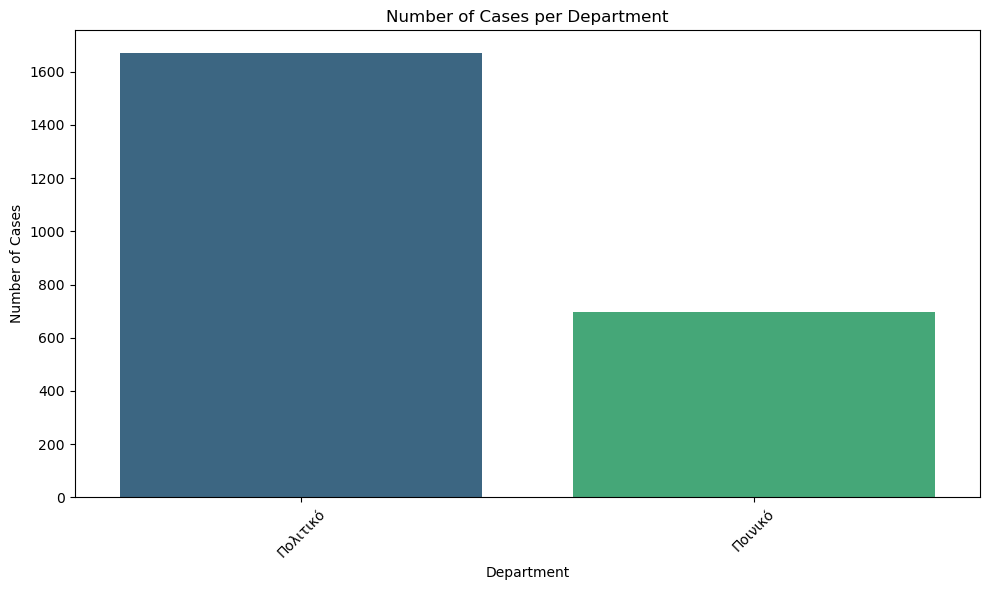

In [21]:
# Group by department and count entries
department_counts = df['department'].value_counts()

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=department_counts.index, y=department_counts.values, palette="viridis")
plt.title("Number of Cases per Department")
plt.xlabel("Department")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


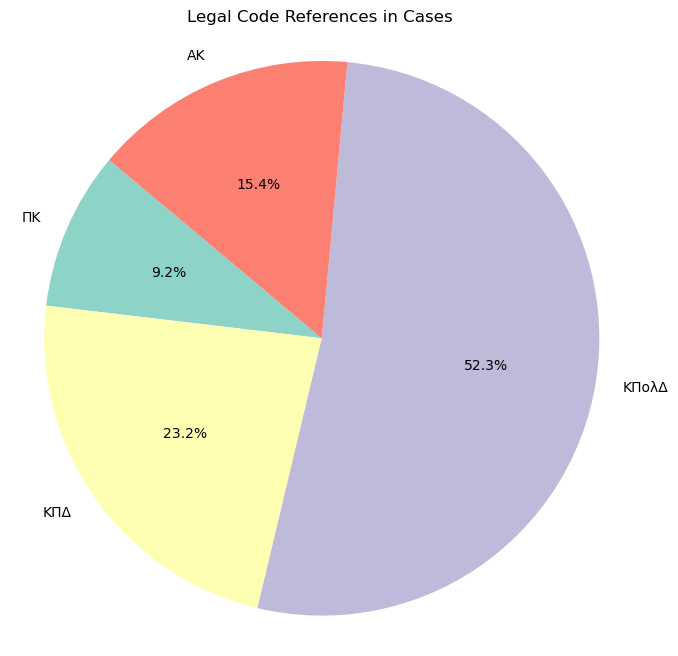

In [22]:
# List of legal code columns
legal_codes = ['ΠΚ', 'ΚΠΔ', 'ΚΠολΔ', 'ΑΚ']

# Count how many non-empty (or non-null) entries exist for each code
code_counts = {}
for code in legal_codes:
    code_counts[code] = df[code].apply(len).sum()

# Plot as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(code_counts.values(), labels=code_counts.keys(), autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
plt.title("Legal Code References in Cases")
plt.axis('equal')  # Equal aspect ratio ensures the pie is a circle.
plt.show()

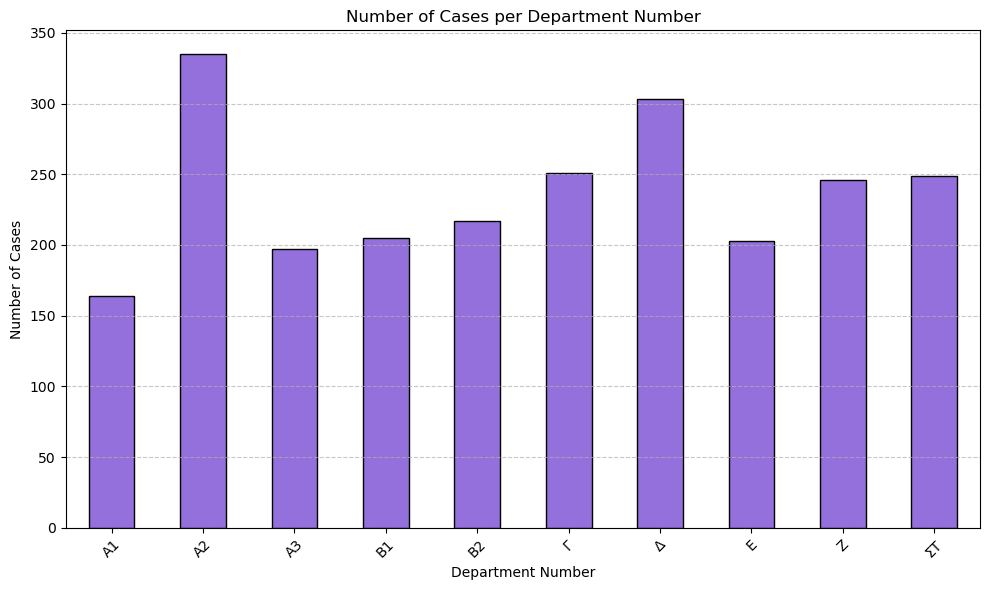

In [23]:
# Convert 'department number' to numeric (just in case) and drop NaNs
df['department number'] = df['department number'].astype(str).str.strip()
df = df.dropna(subset=['department number'])

# Count occurrences of each department number
dept_counts = df['department number'].value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(10, 6))
dept_counts.plot(kind='bar', color='mediumpurple', edgecolor='black')
plt.title('Number of Cases per Department Number')
plt.xlabel('Department Number')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

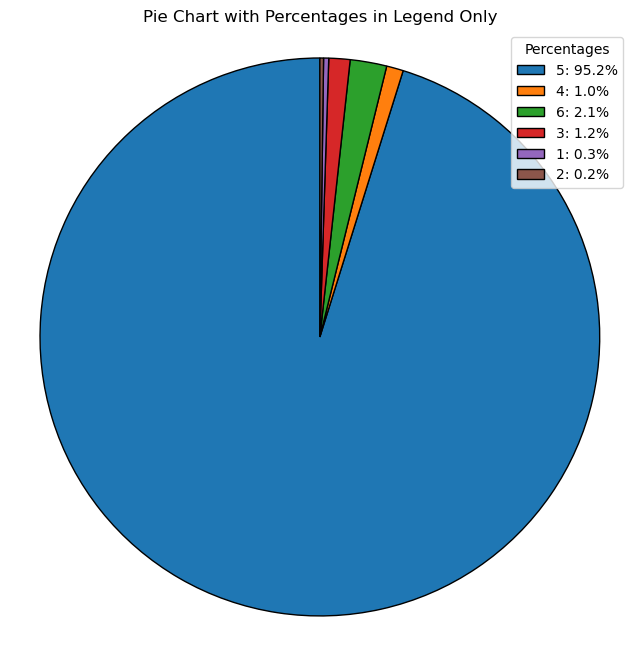

In [24]:
NumOfJudges = {}

for text in df["judges"]:
    match = re.search(r"(?:Συγκροτήθηκε|ΣΥΓΚΡΟΤΗΘΗΚΕ) από τους (?:Δικαστές|δικαστές)[,:]?\s*([^\.]+)", text)
    if match:
        names_str = match.group(1)
        names = re.split(r",\s*|και\s+", names_str)
        names = [name.strip() for name in names]
        if(len(names) not in NumOfJudges.keys()):
            NumOfJudges[len(names)] = 1
        else:
            NumOfJudges[len(names)] += 1


labels = [str(key) for key in NumOfJudges.keys()]
sizes = list(NumOfJudges.values())

total = sum(sizes)

# Calculate the total sum of values
total = sum(sizes)

# Calculate the percentages
percentages = [value / total * 100 for value in sizes]

# Create the pie chart without displaying percentages on the slices
plt.figure(figsize=(8, 8))
plt.pie(sizes, startangle=90, wedgeprops={'edgecolor': 'black'})

# Add a legend with the percentages
legend_labels = [f'{label}: {percent:.1f}%' for label, percent in zip(labels, percentages)]
plt.legend(legend_labels, title="Percentages", loc="best")

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Title for the chart
plt.title('Pie Chart with Percentages in Legend Only')

# Display the plot
plt.show()